# Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import required libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from fiona.crs import from_epsg
from geopandas import GeoDataFrame
import statsmodels.api as sm
import shapely
import pysal as ps
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

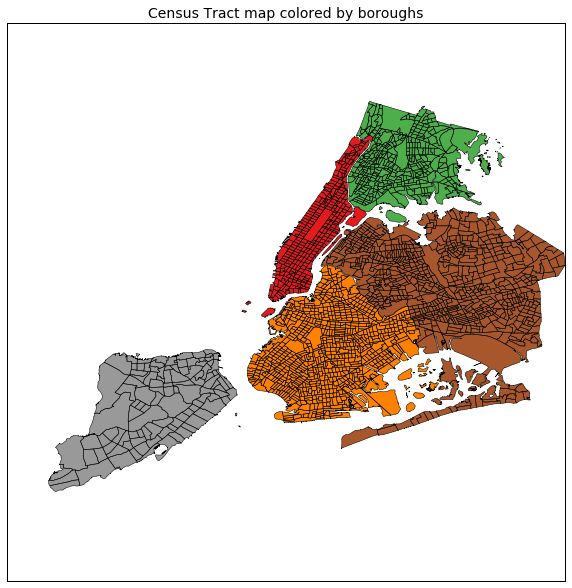

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs", fontsize= 14)

### Figure 1: The above map shows the NYC boroughs with the Census Tracts(CT)

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

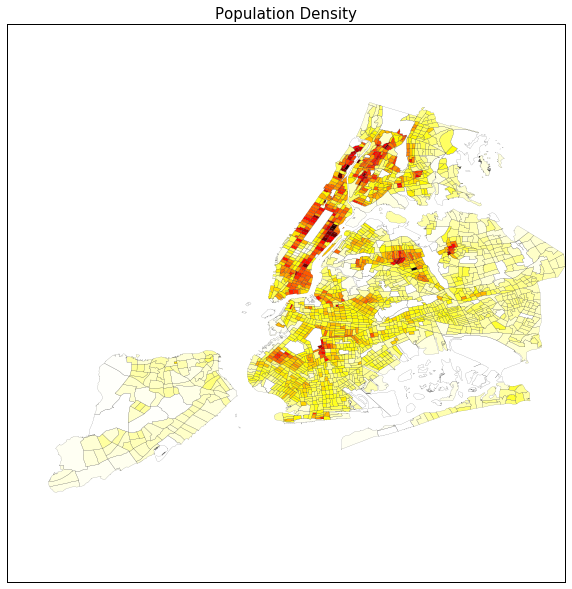

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density", fontsize = 15)

#### Figure 2: The map above shows the NYC population density for the CT's from the data collected in 2010 census. It is visible that the manhattan has more densly populated areas 

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Split Summer (months: June to Sept.) & Winter (months: December to March)

In [10]:
# Split data into summer months(June to September)
df_bike_summer = df_bike_monthly[((df_bike_monthly.index).month >= 6 ) & 
                            ((df_bike_monthly.index).month <= 9)]
# Split data into winter months
df_bike_winter = df_bike_monthly[((df_bike_monthly.index).month >= 12 ) | 
                            ((df_bike_monthly.index).month <= 3)]

### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

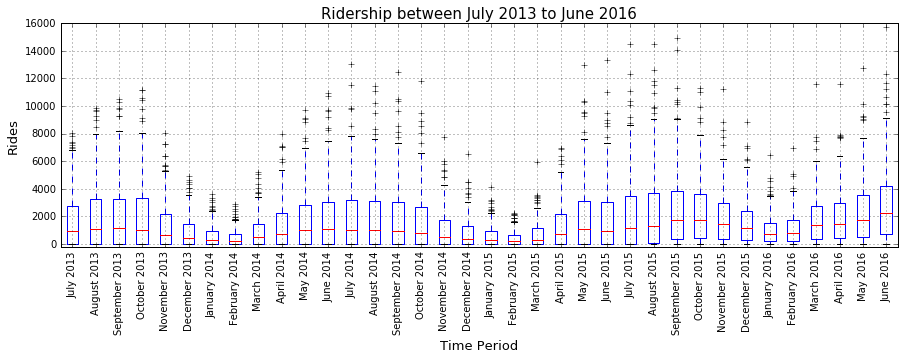

In [11]:
f, ax1 = plt.subplots(figsize=(15, 4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(ax=ax1,rot=90);
ax1.set_title('Ridership between July 2013 to June 2016', fontsize = 15)
ax1.set_xlabel('Time Period', fontsize = 13)
ax1.set_ylabel('Rides', fontsize = 13)
ax1.set_ylim([-200,16000])

#### Figure 3: The above boxplot shows variations of the citibike ridership from 2013 to 2016. We can see the ridership follows a periodic pattern with less ridership in winter  

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

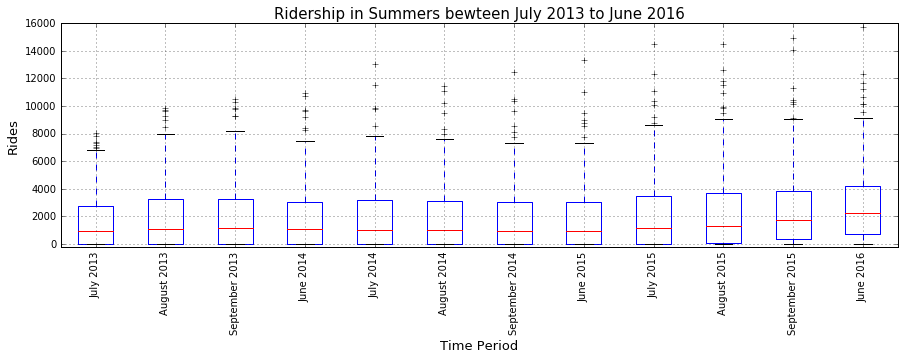

In [12]:
f, ax2 = plt.subplots(figsize=(15, 4))
#create a copy of the df for the viz purposes
df_bike_summer_=df_bike_summer.copy()
df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(ax=ax2,rot=90)
ax2.set_title('Ridership in Summers bewteen July 2013 to June 2016', fontsize = 15)
ax2.set_xlabel('Time Period', fontsize = 13)
ax2.set_ylabel('Rides', fontsize = 13)
ax2.set_ylim([-200,16000])

#### Figure 4: The above boxplot shows variations of the citibike ridership from 2013 to 2016 in summer months(June to Sept.). We can see a litte increase in the rides of citibikes as years increase

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

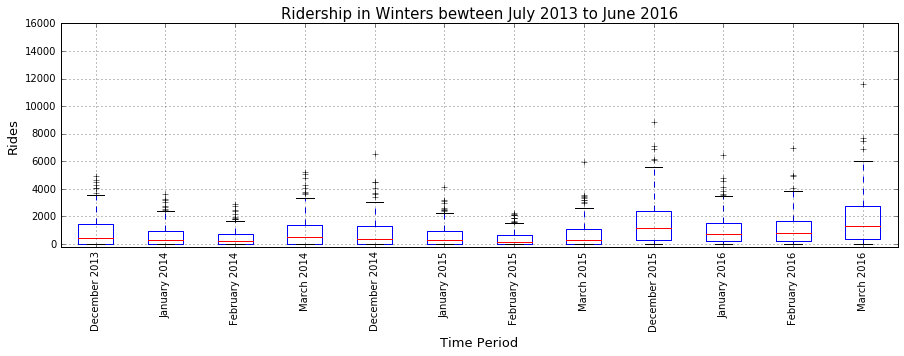

In [13]:
f, ax3 = plt.subplots(figsize=(15, 4))
#create a copy of the df for the viz purposes
df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(ax=ax3,rot=90);
ax3.set_title('Ridership in Winters bewteen July 2013 to June 2016', fontsize = 15)
ax3.set_xlabel('Time Period', fontsize = 13)
ax3.set_ylabel('Rides', fontsize = 13)
ax3.set_ylim([-200,16000])

#### Figure 5: The above boxplot shows variations of the citibike ridership from 2013 to 2016 in winter months(December to March). The rides are less as compared to the rides of citibikes in summer as seen in figure 4

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


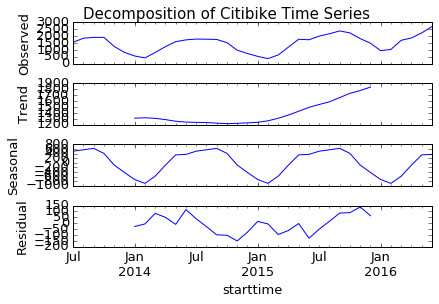

In [14]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
resplot = res.plot()
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']= 13
resplot.suptitle('Decomposition of Citibike Time Series',fontsize = 15, 
                x = 0.5, y = 1)

#### Figure 6: The above figures shows the time series decomposition of the citibike data. It is observed that there is a trend in the data and a seasonal pattern which is similar to what is observed in the boxplot graph

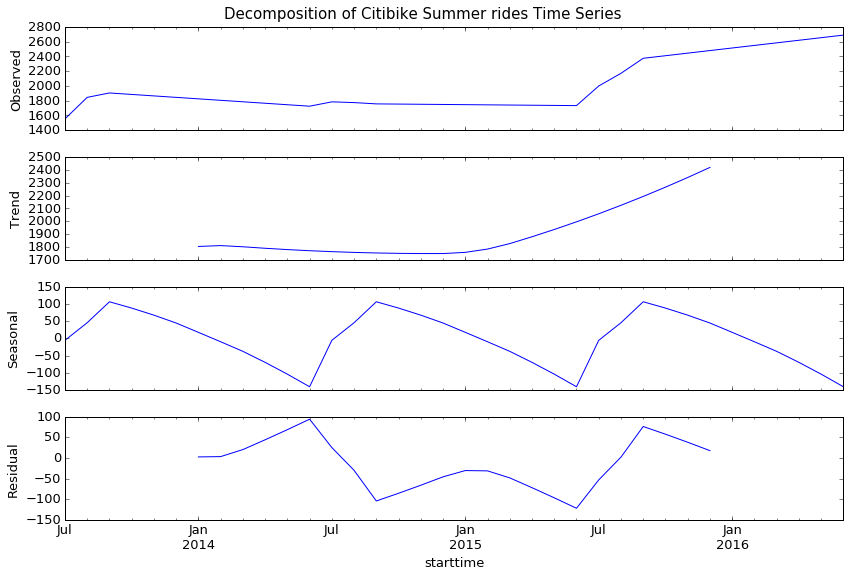

In [15]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new_summer =df_bike_summer.mean(1).resample('M').mean()
df_new_summer.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res_summer = sm.tsa.seasonal_decompose(df_new_summer.dropna())
resplot_summer = res_summer.plot()
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']= 13
resplot_summer.suptitle('Decomposition of Citibike Summer rides Time Series ',fontsize = 15, 
                x = 0.5, y = 1)

#### Figure 7: The above figures shows the time series decomposition of the citibike summer data. It is observed that there is a trend in the data and a seasonal pattern.

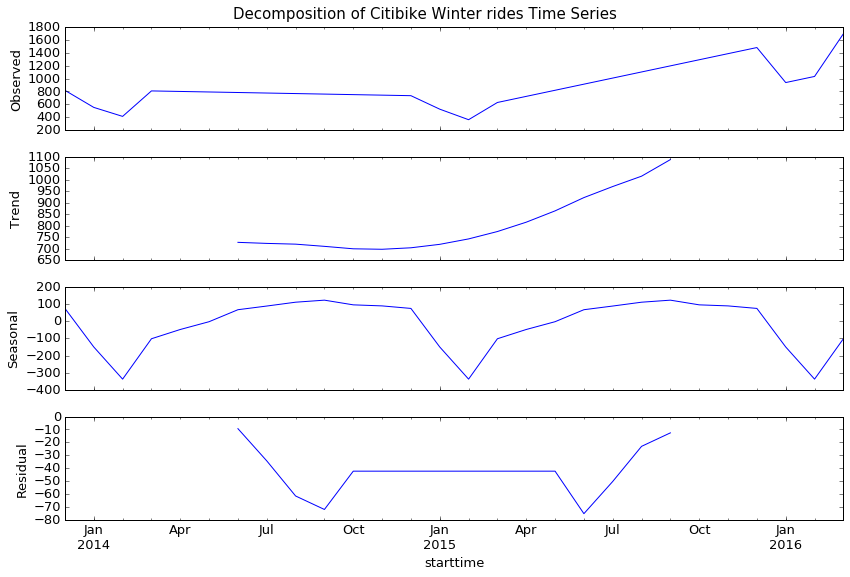

In [16]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new_winter =df_bike_winter.mean(1).resample('M').mean()
df_new_winter.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res_winter = sm.tsa.seasonal_decompose(df_new_winter.dropna())
resplot_winter = res_winter.plot()
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']= 13
resplot_winter.suptitle('Decomposition of Citibike Winter rides Time Series',fontsize = 15, 
                x = 0.5, y = 1)

#### Figure 8: The above figures shows the time series decomposition of the citibike winter rides data. It is observed that there is a trend in the data and a seasonal pattern

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [17]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [18]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [19]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [20]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [21]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve']=df_bike_monthly.sum()
station_id['MA_Summer']=df_bike_summer.sum()
station_id['MA_Winter']=df_bike_winter.sum()

### Add the monthly average rides to the CT shapefile 

In [22]:
# use the 
temp=station_id[['MonthlyAve']]
temp_summer = station_id[['MA_Summer']]
temp_winter = station_id[['MA_Winter']]

temp['station_id']=station_id.index
temp_summer['station_id']=station_id.index
temp_winter['station_id']=station_id.index

temp.index=station_id['BoroCT2010']
temp_summer.index=station_id['BoroCT2010']
temp_winter.index=station_id['BoroCT2010']

ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve_Summer=ct_shape.join(temp_summer)
ct_shape_MonthlyAve_Winter=ct_shape.join(temp_winter)

ct_shape_MonthlyAve.fillna(0,inplace=True)
ct_shape_MonthlyAve_Winter.fillna(0,inplace=True)
ct_shape_MonthlyAve_Summer.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

### Map the zommed CT's by monthly, summer and winter data 

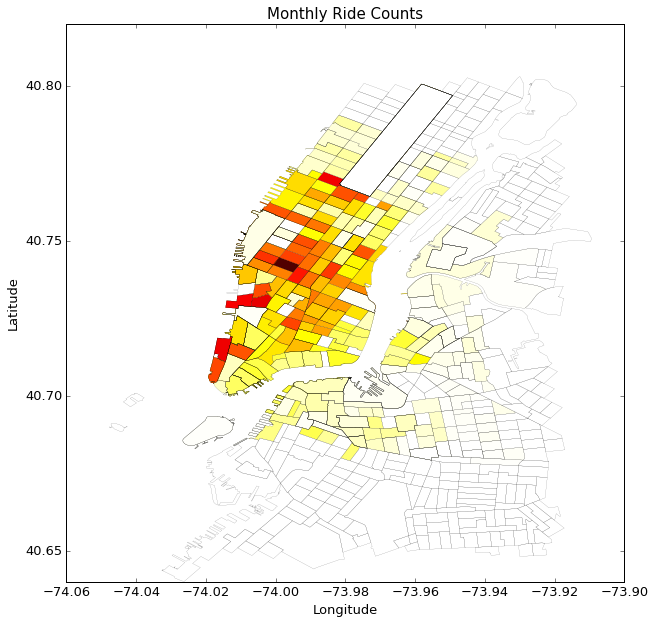

In [23]:
f, ax = plt.subplots(figsize=(10,10))

ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and 
                                  c.x<-73.92 and 
                                  c.y>40.65 and 
                                  c.y<40.8)])

ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',cmap='hot_r',
                         alpha=1,linewidth=0.1,ax=ax)
plt.xlabel('Longitude', fontsize = 13)
plt.ylabel('Latitude', fontsize = 13)
plt.title("Monthly Ride Counts", fontsize = 15)


#### Figure 9: The above maps shows the counts of citibike riders in the CT's from 2013 to 2016. It is clearly visible that the most of the rides are in Manhattan around NYU campus

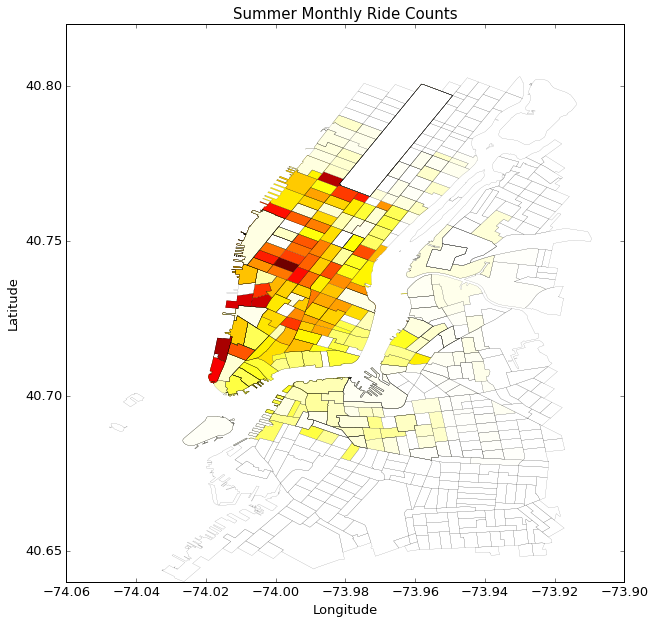

In [24]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Summer_Zoom=(ct_shape_MonthlyAve_Summer[ct_shape_MonthlyAve_Summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and 
                                  c.x<-73.92 and 
                                  c.y>40.65 and 
                                  c.y<40.8)])
ct_shape_MonthlyAve_Summer_Zoom.plot(column='MA_Summer',cmap='hot_r',
                         alpha=1,linewidth=0.1,ax=ax)
plt.xlabel('Longitude', fontsize = 13)
plt.ylabel('Latitude', fontsize = 13)
plt.title("Summer Monthly Ride Counts", fontsize = 15)

#### Figure 10: The above maps shows the counts of citibike riders in the CT's during summers from 2013 to 2016. It is clearly visible that the most of the rides are in Manhattan around NYU campus

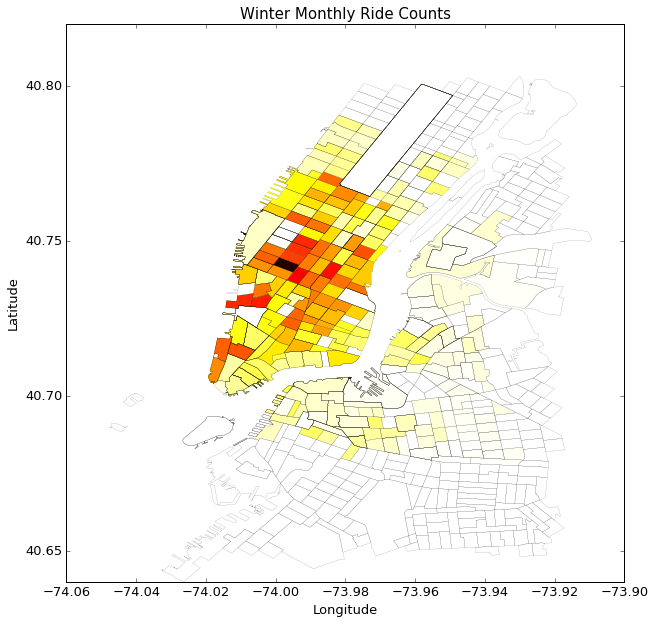

In [25]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Winter_Zoom=(ct_shape_MonthlyAve_Winter[ct_shape_MonthlyAve_Winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and 
                                  c.x<-73.92 and 
                                  c.y>40.65 and 
                                  c.y<40.8)])
ct_shape_MonthlyAve_Winter_Zoom.plot(column='MA_Winter',cmap='hot_r',
                         alpha=1,linewidth=0.1,ax=ax)
plt.xlabel('Longitude', fontsize = 13)
plt.ylabel('Latitude', fontsize = 13)
plt.title("Winter Monthly Ride Counts", fontsize = 15)

#### Figure 11: The above maps shows the counts of citibike riders in the CT's during winters from 2013 to 2016. It is clearly visible that the most of the rides are in Manhattan around NYU campus and the count is also reduced as seen in some parts where the colour density has reduced (eg. bottom CT's of central park) 

In [26]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

### Export Shapefile CTs in the CitiBike Zone

In [27]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
pathS='Output/ct_shape_MonthlyAve_Summer_Zoom.shp'
pathW='Output/ct_shape_MonthlyAve_Winter_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)
ct_shape_MonthlyAve_Summer_Zoom.to_file(pathS)
ct_shape_MonthlyAve_Winter_Zoom.to_file(pathW)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [28]:
qW_CT = ps.queen_from_shapefile(path)
qW_CTS = ps.queen_from_shapefile(pathS)
qW_CTW = ps.queen_from_shapefile(pathW)

('Island id: ', [0])
('Island id: ', [0])
('Island id: ', [0])


#### Neighbors of index10

In [29]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [30]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [31]:
Wmatrix, ids = qW_CT.full()
Wmatrix_summer, ids_summer = qW_CTS.full()
Wmatrix_winter, ids_winter = qW_CTW.full()

In [32]:
Wmatrix_summer

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [33]:
qW_CT.transform = 'r'
qW_CTS.transform = 'r'
qW_CTW.transform = 'r'


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [34]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)
MonthlyRide_Summer=ct_shape_MonthlyAve_Summer_Zoom.MA_Summer
MonthlyRideLag_Summer=ps.lag_spatial(qW_CTS, MonthlyRide_Summer)
MonthlyRide_Winter=ct_shape_MonthlyAve_Winter_Zoom.MA_Winter
MonthlyRideLag_Winter=ps.lag_spatial(qW_CTW, MonthlyRide_Winter)

#### Create Quantiles for maping

In [35]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10_Summer = ps.Quantiles(MonthlyRideLag_Summer, k=10)
MonthlyRideLagQ10_Winter = ps.Quantiles(MonthlyRideLag_Winter, k=10)
MonthlyRideLagQ10_Winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    55.143                 2
   55.143 < x[i] <=   902.271                78
  902.271 < x[i] <=  2165.333                80
 2165.333 < x[i] <=  3452.913                79
 3452.913 < x[i] <=  5014.083                80
 5014.083 < x[i] <= 11249.113                79
11249.113 < x[i] <= 15205.882                80
15205.882 < x[i] <= 18477.420                79
18477.420 < x[i] <= 29902.786                80

#### Map the monthly rides lag

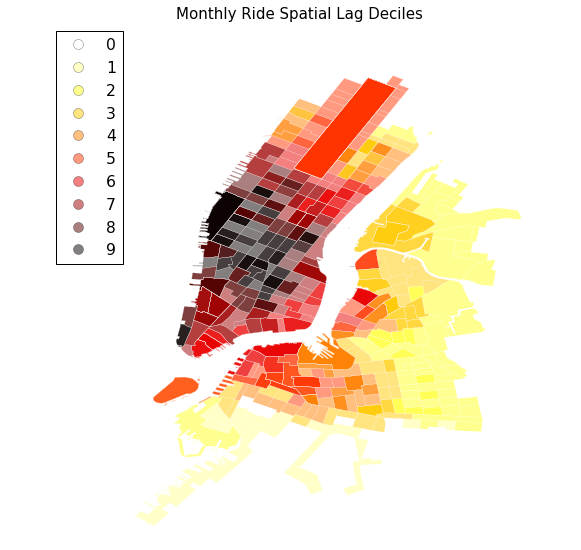

In [36]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles", fontsize = 15)


#### Figure 12: The above map shows the spatial lag of the citibike rides for 2013 to 2016. 

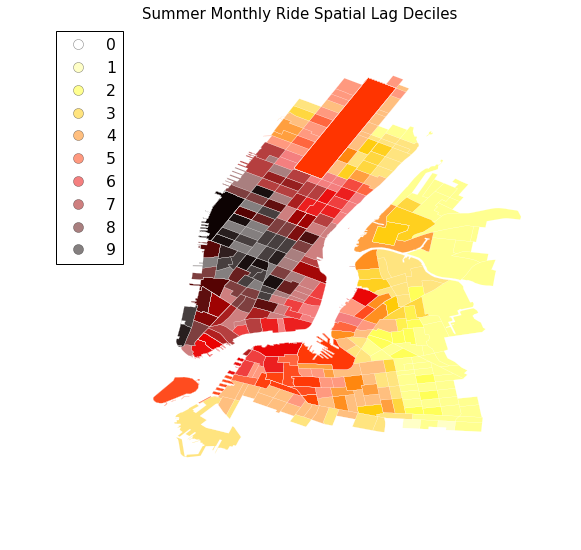

In [37]:
f, ax1 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Summer_Zoom.assign(cl=MonthlyRideLagQ10_Summer.yb).\
plot(column='cl', categorical=True, 
     k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
     edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles", fontsize = 15)


#### Figure 13: The above map shows the spatial lag of the citibike rides for summer months in 2013 to 2016. 

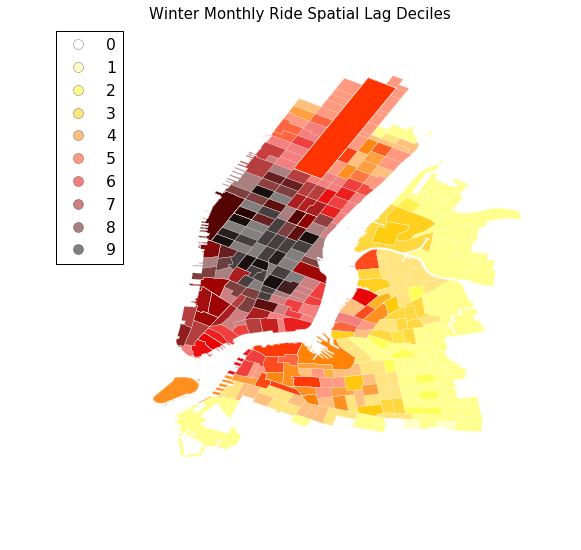

In [38]:
f, ax2 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Winter_Zoom.assign(cl=MonthlyRideLagQ10_Winter.yb).\
plot(column='cl', categorical=True, 
     k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
     edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles", fontsize = 15)


#### Figure 14: The above map shows the spatial lag of the citibike rides for winter months in 2013 to 2016. 

## Global  Spatial Autocorrelation

In [39]:
b, a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b_summer, a_summer = np.polyfit(MonthlyRide_Summer, MonthlyRideLag_Summer, 1)
b_winter,a_winter = np.polyfit(MonthlyRide_Winter, MonthlyRideLag_Winter, 1)
b_summer,a_summer 

(0.6438931431258913, 5682.9310787418508)

### Moran Scatterplot

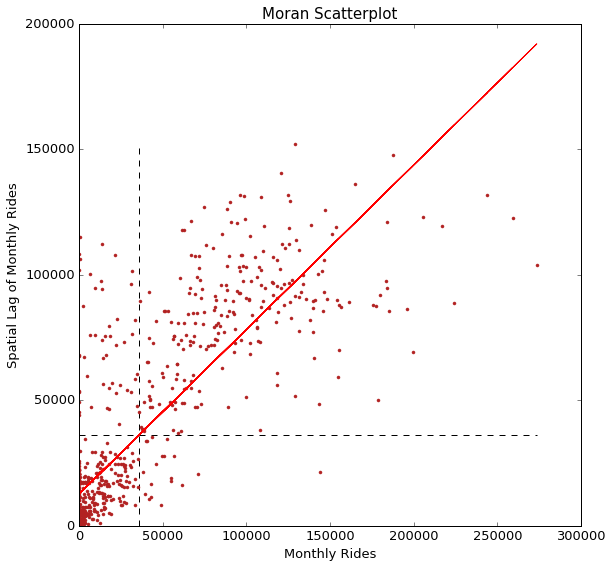

In [40]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot', fontsize = 15)
plt.ylabel('Spatial Lag of Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 15: The above plot displays the Moran Scatterplot for the monthly rides for citibikes. There is a positive spatial correlation.

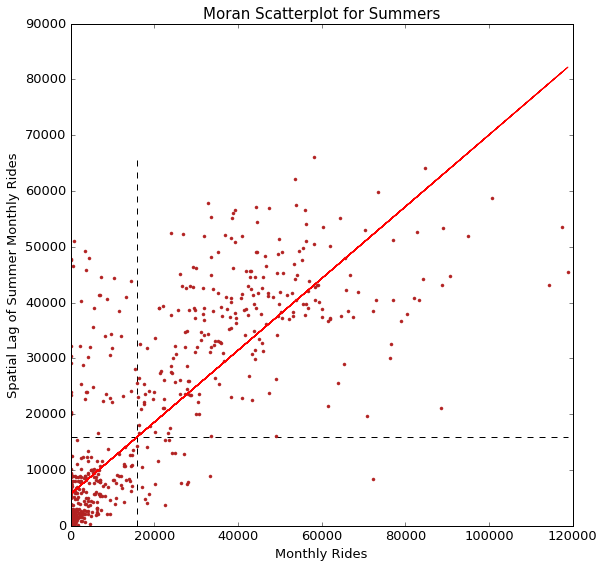

In [41]:
f, ax1 = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_Summer, MonthlyRideLag_Summer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Summer.mean(), MonthlyRideLag_Summer.min(), 
           MonthlyRideLag_Summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Summer.mean(), MonthlyRide_Summer.min(), 
           MonthlyRide_Summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Summer, a_summer + b_summer*MonthlyRide_Summer, 'r')
plt.title('Moran Scatterplot for Summers', fontsize = 15)
plt.ylabel('Spatial Lag of Summer Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 16: The above plot displays the Moran Scatterplot for the monthly rides in summer for citibikes. There is a positive spatial correlation.

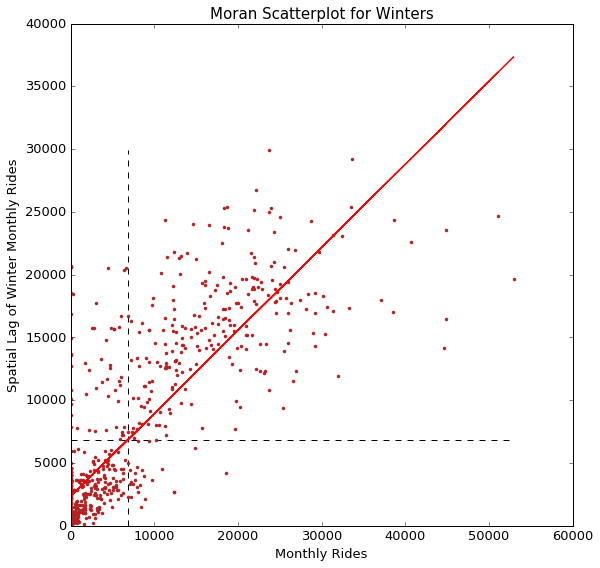

In [42]:
f, ax2 = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_Winter, MonthlyRideLag_Winter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Winter.mean(), MonthlyRideLag_Winter.min(),
           MonthlyRideLag_Winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Winter.mean(), MonthlyRide_Winter.min(), 
           MonthlyRide_Winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Winter, a_winter + b_winter*MonthlyRide_Winter, 'r')
plt.title('Moran Scatterplot for Winters', fontsize = 15)
plt.ylabel('Spatial Lag of Winter Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 17: The above plot displays the Moran Scatterplot for the monthly rides in winter for citibikes. There is a positive spatial correlation.

### Moran's I

In [43]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)
I_MonthlyRide_Summer = ps.Moran(MonthlyRide_Summer, qW_CTS)
I_MonthlyRide_Winter = ps.Moran(MonthlyRide_Winter, qW_CTW)

In [44]:
print 'Monthly:',I_MonthlyRide.I, I_MonthlyRide.p_sim
print 'Summer:', I_MonthlyRide_Summer.I, I_MonthlyRide_Summer.p_sim
print 'Winter:', I_MonthlyRide_Winter.I, I_MonthlyRide_Winter.p_sim

Monthly: 0.655793329084 0.001
Summer: 0.644069499068 0.001
Winter: 0.662044196711 0.001


# The $I$ statistic is greater than 0 for this data, and has a very small $p$ value. I.e there is spatial correlation 

In [45]:
I_MonthlyRide.sim[0:10]

array([ 0.0012033 ,  0.00114889,  0.01589536, -0.01345222,  0.02508344,
       -0.00554469,  0.00977455, -0.01672005,  0.01549631,  0.01830018])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [46]:
import seaborn as sns

In [47]:
plt.rcParams['figure.figsize']=(14,3)

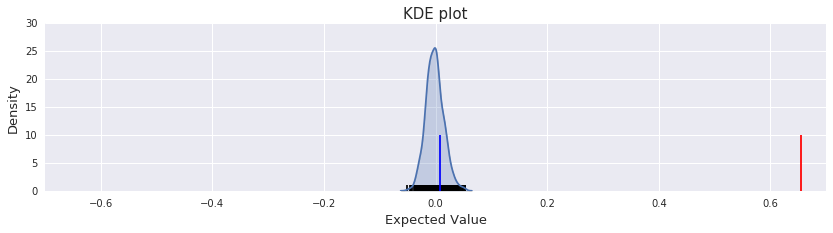

In [48]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'blue')
plt.xlim([-.70, .70])
plt.title('KDE plot', fontsize = 15)
plt.xlabel('Expected Value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

### Figure 18: In the above figure the vertical line is showing that our $I$ statistic(red) is away from our expected $I$(blue) value under normality assumption

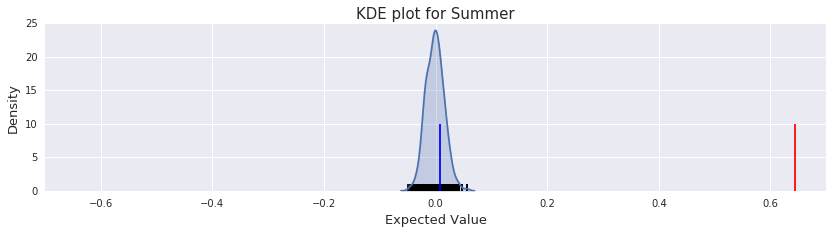

In [49]:
sns.kdeplot(I_MonthlyRide_Summer.sim, shade=True)
plt.vlines(I_MonthlyRide_Summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_Summer.I, 0, 10, 'r')
plt.vlines(I_MonthlyRide_Summer.EI+.01, 0, 10, 'blue')
plt.xlim([-.70, .70])
plt.title('KDE plot for Summer', fontsize = 15)
plt.xlabel('Expected Value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)


### Figure 19: In the above figure the vertical line is showing that our $I$ statistic(red) for summers is away from our expected $I$ value(blue) under normality assumption

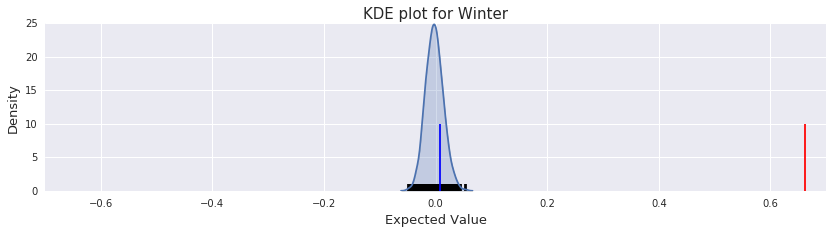

In [50]:
sns.kdeplot(I_MonthlyRide_Winter.sim, shade=True)
plt.vlines(I_MonthlyRide_Winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_Winter.I, 0, 10, 'r')
plt.vlines(I_MonthlyRide_Winter.EI+.01, 0, 10, 'blue')
plt.xlim([-.70, .70])
plt.title('KDE plot for Winter', fontsize = 15)
plt.xlabel('Expected Value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

### Figure 20: In the above figure the vertical line is showing that our $I$ statistic(red) for winters is away from our expected $I$ value(blue) under normality assumption

## Local  Spatial Autocorrelation

In [51]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)
LMo_MonthlyRide_Summer = ps.Moran_Local(MonthlyRide_Summer, qW_CTS,permutations=999)
LMo_MonthlyRide_Winter = ps.Moran_Local(MonthlyRide_Winter, qW_CTW,permutations=999)

In [52]:
LMo_MonthlyRide_Winter.Is[0:5], LMo_MonthlyRide_Winter.p_sim[0:5]

(array([-0.        , -0.3153042 , -0.00110645, -0.00100209, -0.06082761]),
 array([ 0.001,  0.142,  0.449,  0.495,  0.432]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [53]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

sigs_summer = MonthlyRide_Summer[LMo_MonthlyRide_Summer.p_sim <= .001]
W_sigs_summer = MonthlyRideLag_Summer[LMo_MonthlyRide_Summer.p_sim <= .001]
insigs_summer = MonthlyRide_Summer[LMo_MonthlyRide_Summer.p_sim > .001]
W_insigs_summer = MonthlyRideLag_Summer[LMo_MonthlyRide_Summer.p_sim > .001]

sigs_winter = MonthlyRide_Winter[LMo_MonthlyRide_Winter.p_sim <= .001]
W_sigs_winter = MonthlyRideLag_Winter[LMo_MonthlyRide_Winter.p_sim <= .001]
insigs_winter = MonthlyRide_Winter[LMo_MonthlyRide_Winter.p_sim > .001]
W_insigs_winter = MonthlyRideLag_Winter[LMo_MonthlyRide_Winter.p_sim > .001]

### Plot Signficant LISA

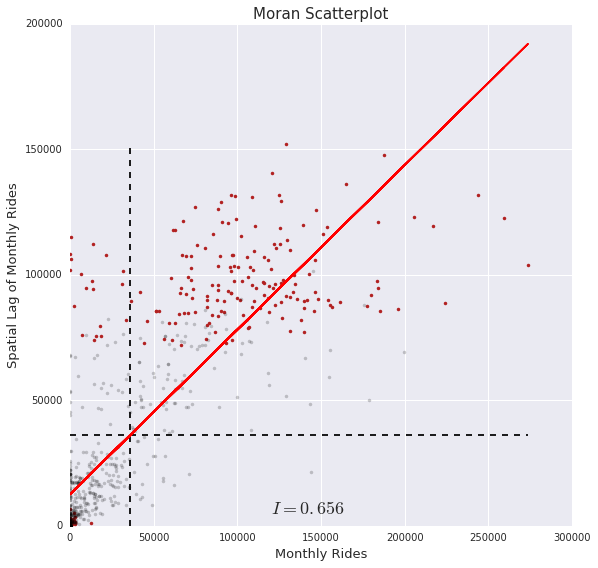

In [54]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot', fontsize = 15)
plt.ylabel('Spatial Lag of Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)


### Figure 21: The above figure shows the moran scatter plot. There is a positivite spatial correlation

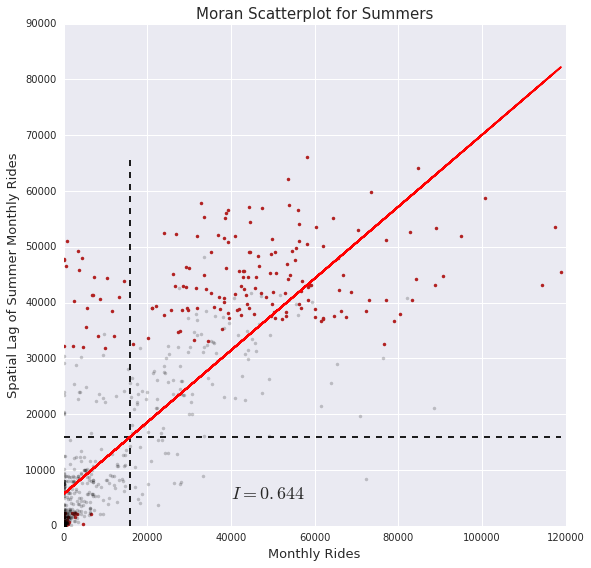

In [55]:
f, ax1 = plt.subplots(figsize=(9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_Summer.I, x=40000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Summer.mean(), MonthlyRideLag_Summer.min(), 
           MonthlyRideLag_Summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Summer.mean(), MonthlyRide_Summer.min(), 
           MonthlyRide_Summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Summer, a_summer + b_summer*MonthlyRide_Summer, 'r')
plt.title('Moran Scatterplot for Summers', fontsize = 15)
plt.ylabel('Spatial Lag of Summer Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 22: The above figure shows the moran scatter plot for summers. There is a positivite spatial correlation

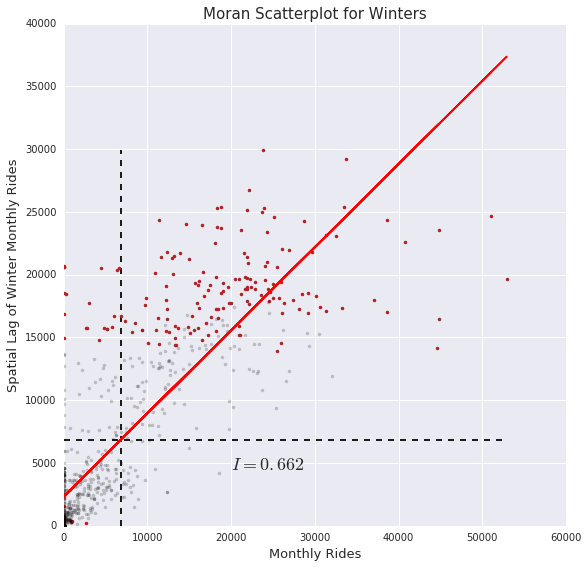

In [56]:
f, ax2 = plt.subplots(figsize=(9, 9))
plt.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_Winter.I, x=20000, y=4500, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Winter.mean(), MonthlyRideLag_Winter.min(), 
           MonthlyRideLag_Winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Winter.mean(), MonthlyRide_Winter.min(), 
           MonthlyRide_Winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Winter, a_winter + b_winter*MonthlyRide_Winter, 'r')
plt.title('Moran Scatterplot for Winters', fontsize = 15)
plt.ylabel('Spatial Lag of Winter Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 23: The above figure shows the moran scatter plot for winters. There is a positivite spatial correlation

### Hot and Cold spots 

In [57]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 192
Number of Coldspots: 233


In [58]:
sig_summer = LMo_MonthlyRide_Summer.p_sim < 0.01
hotspots_summer = LMo_MonthlyRide_Summer.q==1 * sig_summer
coldspots_summer = LMo_MonthlyRide_Summer.q==3 * sig_summer
print "Number of Hotspots:", hotspots_summer.sum()
print "Number of Coldspots:", coldspots_summer.sum()

Number of Hotspots: 188
Number of Coldspots: 243


In [59]:
sig_winter = LMo_MonthlyRide_Winter.p_sim < 0.01
hotspots_winter = LMo_MonthlyRide_Winter.q==1 * sig_winter
coldspots_winter = LMo_MonthlyRide_Winter.q==3 * sig_winter
print "Number of Hotspots:", hotspots_winter.sum()
print "Number of Coldspots:", coldspots_winter.sum()

Number of Hotspots: 193
Number of Coldspots: 214


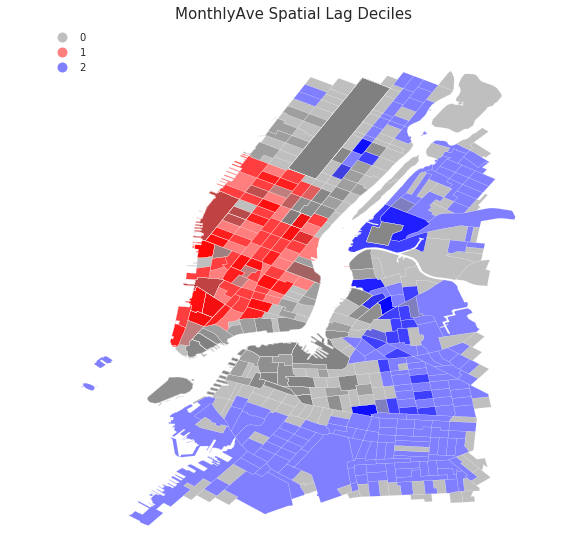

In [60]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
         cmap=hcmap, linewidth=0.1, ax=ax, 
         edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles", fontsize = 15)

### Figure 24: The Map shows the cold spots and hot spots of the citibike rides. It is visible that high rides CT's are closer to each other

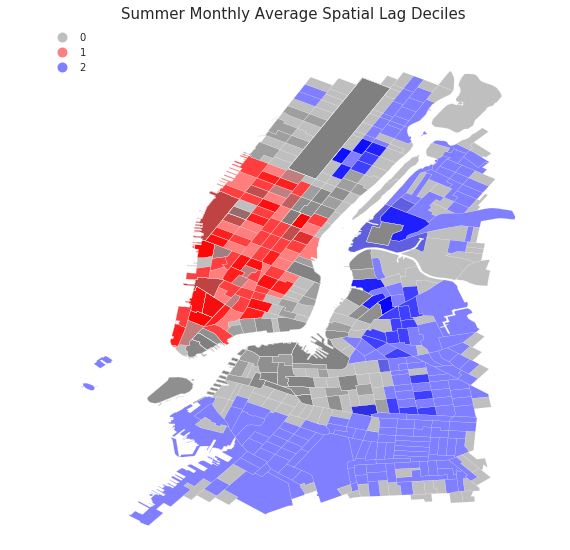

In [61]:
hcmap_summer = colors.ListedColormap(['grey','red','blue'])
hotcold_summer = hotspots_summer*1 + coldspots_summer*2

f, ax1 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Summer_Zoom.assign(cl=hotcold_summer).plot(column='cl', 
         categorical=True, 
         cmap=hcmap_summer, linewidth=0.1, ax=ax1, 
         edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Summer Monthly Average Spatial Lag Deciles", fontsize = 15)

### Figure 25: The Map shows the cold spots and hot spots of the citibike rides in summer. Shades of Blue are coldspots and red are hotspots

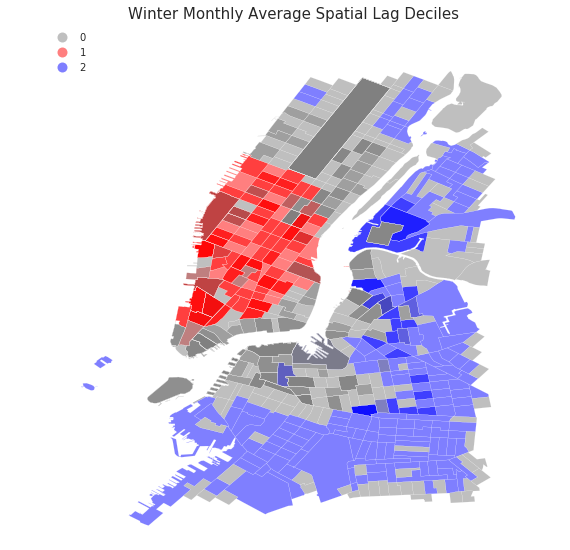

In [62]:
hcmap_winter = colors.ListedColormap(['grey','red','blue'])
hotcold_winter = hotspots_winter*1 + coldspots_winter*2

f, ax2 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Winter_Zoom.assign(cl=hotcold_winter).plot(column='cl', 
         categorical=True, 
         cmap=hcmap_winter, linewidth=0.1, ax=ax2, 
         edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("Winter Monthly Average Spatial Lag Deciles", fontsize = 15)

### Figure 26: The Map shows the cold spots and hot spots of the citibike rides in winters. Shades of Blue are coldspots and red are hotspots, the cold and hotspots differ in the summer and winter(eg. right side of central park)